<a href="https://colab.research.google.com/github/ankit986/HEALTH-INSURANCE-CROSS-SELL-PREDICTION/blob/main/HEALTH_INSURANCE_CROSS_SELL_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**
---

In [1]:
#@title

# Basic
import numpy as np
import pandas as pd

# Plotation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# ML Models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# Miscellaneous
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# **Reading Dataset**
---

Let's read the dataset we have to work on! We have a dataset of Health Insurance details.


In [2]:
train = pd.read_csv("C:\\Users\\USER-PC\\Desktop\\ThesisCode\\\Data\\Raw\\balanced_dataset_colon.csv")
test  = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\\Data\\Preprocessed\\aug_test_processed.csv')
answers = np.load('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\\Data\\Raw\\answer.npy')

# Separate features and target
X_train = train.drop('Response', axis=1)
y_train = train['Response']
X_test = test.drop('id', axis=1)  # Assuming 'id' column is not needed for prediction


# **Machine Learning Algorithms**
---


Let's apply different Machine Learning Models to our data set and see how each of them performs. Firstly, We will tune the hyper-parameters of those models and then we will compare and choose the best model among them, based on Elapsed Time and Evaluation Metrics of the best parameters. 

List of **Machine Learning Models** we are going to train and evaluate our data set on:
- Decision Tree
- Gaussian Naive Bayes
- AdaBoost Classifier
- Bagging Classifier
- LightGBM
- Logistic Regression

###**Hyper-Parameter Tuning Methods:**

We have tried different hyper-parameter tuning methods. Every method gave the same result but **GridSearchCV** and **RandomizedSearchCV** took a huge amount of time to train the models. **HalvingRandomizedSearchCV** took the least time to train the models and predict the output. That's why we highly ***recommend*** you to keep the Tuning_Method as Halving_Randomized_Search_CV from the drop-down menu below.

We have also added some results of the model tuning with GridSearchCV and RandomizedSearchCV, just for performance comparison.

#### **Tuning Methods:**
- HalvingRandomizedSearchCV
- GridSearchCV
- RandomizedSearchCV

### **Evaluation Metrics:**
- Accuracy Score
- Precision
- Recall
- F1 Score
- ROC AUC Score
- Log Loss

### **Plots:**

At the end of every model's hyper-parameter tuning, there is one **ROC Curve** which shows the ROC Scores and **Parallel Coordinates Plot** which shows all the combinations of hyper-parameters used for tuning the model to get the best parameters.


*Let's get started...!*

In [3]:
def plot_confusion_matrix_and_roc_curves(model, X_test, y_test, y_pred):

    pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, pred_proba, pos_label=1)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))  # Set the figure size as needed
    plt.plot(fpr, tpr, linestyle='--', color='red', label=f'{type(model).__name__} (AUC = {roc_auc_score(y_test, pred_proba):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')  # This is the line for random chance

    # Adding labels and title
    plt.title('ROC Curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})

    # Adding a legend
    plt.legend(loc='best')
    plt.show()
   


def visualization(results_df, parameters):    

    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(shorten_param, axis=1)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
    results_df,
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
    title='Hyper Parameter Tuning',)
    fig.show()


def evaluation_metrics(name, independent_feature_length , y_pred, y_test):

    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = [accuracy_score(y_test,y_pred)]  #Accuracy Score
    metrics_dict['Geo Mean'] = [geometric_mean_score(y_test,y_pred)] #Precision
    metrics_dict['Recall'] = [recall_score(y_test,y_pred)] #Recall
    metrics_dict['F1_Score'] = [f1_score(y_test,y_pred, average='weighted')] #F1 Score
    metrics_dict['ROC_AUC_Score'] = [roc_auc_score(y_test, y_pred)] #ROC AUC Score
    metrics_dict['Log_Loss'] = [log_loss(y_test, y_pred)] #Log Loss

    metrics_df = pd.DataFrame(metrics_dict)

    print(metrics_df)


def hyperparameter_tuning(x_train, y_train, model, parameters, tuning_model):

    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions = parameters, scoring = "accuracy", n_jobs=-1, factor=3, cv = 5 )
    
    elif tuning_model == 'Randomized_Search_CV':
        tuned_model = RandomizedSearchCV(model, param_distributions = parameters, scoring = 'accuracy', cv = 3, n_iter = 50, n_jobs=-1)

    else:
        tuned_mode = GridSearchCV(model, param_grid = parameters, scoring = 'accuracy', n_jobs=-1, cv = 3)

    
    start_time = time.time() 
    
    tuned_model.fit(x_train, y_train)
    
    stop_time = time.time()

    print('*****'*10+f'\nBest Score for {type(model).__name__} : {tuned_model.best_score_}','\n---')
    print(f'Best Parameters for {type(model).__name__} : {tuned_model.best_params_}\n'+'-----'*10)

    print('Elapsed Time:',time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print('======'*5)

    return tuned_model


def perform_ml_algorithm(x_train, x_test, y_train, y_test, model, parameters, tuning_model):
    print('-----'*10+f'\n{type(model).__name__}\n'+'-----'*10)

    model.fit(x_train, y_train)
    untuned_pred = model.predict(x_test)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n'+'-----'*10)
    evaluation_metrics(type(model).__name__, len(list(x_train.columns)), untuned_pred, y_test)

    print()
    plot_confusion_matrix_and_roc_curves(model, x_test, y_test, untuned_pred)

    # Hyper-parameter tuning
    tuned_model = hyperparameter_tuning(x_train, y_train, model, parameters, tuning_model)
    tuned_pred = tuned_model.predict(x_test)
  
    # Evaluation Metrics after tuning
    print(f'\nEvaluation of {type(model).__name__} after tuning:\n'+'-----'*10)
    evaluation_metrics(type(model).__name__,len(list(x_train.columns)), tuned_pred, y_test)

    print()
    plot_confusion_matrix_and_roc_curves(tuned_model.best_estimator_, x_test, y_test, tuned_pred)
    #visualization(pd.DataFrame(tuned_model.cv_results_), parameters)


def ml_algorithm_implementation(df, model, parameters, tuning_model, feature_importance = False):

    if feature_importance == False:
        print('########'*8+'\n     <<<< '+f'Tuning Model: {tuning_model}'+' >>>>\n'+'********'*8)

    # Load your datasets
    train_data = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\\Data\\Raw\\balanced_dataset_colon.csv')
    test_data = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\\Data\\Preprocessed\\aug_test_processed.csv')
    answers = np.load('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\\Data\\Raw\\answer.npy')

    # Separate features and target
    X_train_full = train_data.drop('Response', axis=1)
    y_train_full = train_data['Response']
    X_test = test_data.drop('id', axis=1)  # Assuming 'id' column is not needed for prediction

    # Initialize the scaler
    scaler = MinMaxScaler()

    # List of numerical columns to scale
    columns_to_scale = ['Policy_Sales_Channel', 'Vintage', 'Annual_Premium_Treated']

    # Scaling only the specified columns in the training data
    X_train_scaled = X_train_full.copy()  # Create a copy to avoid changing the original data
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_full[columns_to_scale])

    # Scaling only the specified columns in the test data using the same scaler
    X_test_scaled = X_test.copy()  # Create a copy to avoid changing the original data
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


    # Split the train data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_full, test_size=0.2, random_state=42)
    if feature_importance == True:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, X_test_scaled, y_train, answers, model, parameters, tuning_model)

In [4]:
#@title Keep it Halving_Randomized_Search_CV!! Other methods are time consuming.
Tuning_Method = "Halving_Randomized_Search_CV" #@param ["Halving_Randomized_Search_CV", "Grid_Search_CV", "Randomized_Search_CV"]

## **Logistic Regression**
---
The logistic classification model is a binary classification model in which the conditional probability of one of the two possible realizations of the output variable is assumed to be equal to a linear combination of the input variables, transformed by the logistic function.

### ***Hyper-Parameter Tuning:***

> **solver:** Algorithm to use in the optimization problem.

> **penalty:** Specify the norm of the penalty.

> **C:** Inverse of regularization strength

> **random_state:** Controls the randomness of the estimator.

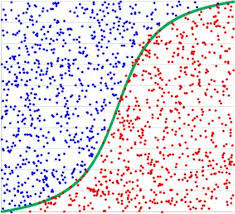

################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
--------------------------------------------------
LogisticRegression
--------------------------------------------------

Evaluation of LogisticRegression before tuning:
--------------------------------------------------
   Accuracy_Score  Geo Mean   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.741392  0.812322  0.93907  0.774374       0.820876  9.321166



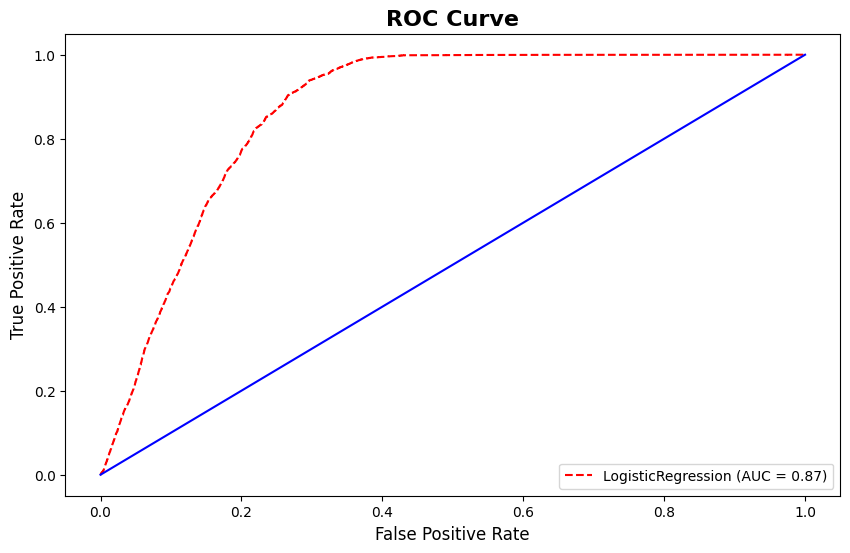

**************************************************
Best Score for LogisticRegression : 0.8864650699870825 
---
Best Parameters for LogisticRegression : {'solver': 'sag', 'random_state': 2, 'penalty': 'l2', 'max_iter': 200, 'class_weight': None, 'C': 10}
--------------------------------------------------
Elapsed Time: 00:00:31

Evaluation of LogisticRegression after tuning:
--------------------------------------------------
   Accuracy_Score  Geo Mean    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.741265  0.812283  0.939226  0.774268       0.820862  9.325771



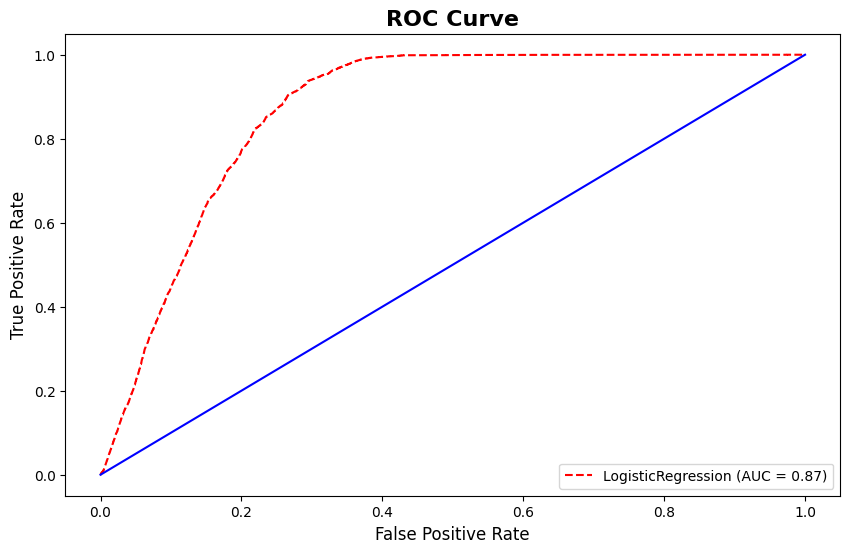

In [5]:
parameters_logistic = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2', 'l1', 'none'],  # Added 'l1' and 'none' for solvers that support it (check compatibility)
    'C': [100, 10, 1.0, 0.1, 0.01, 0.001],
    'class_weight': [None, 'balanced'],  # To handle class imbalance
    'random_state': [2],
    'max_iter': [100, 200, 300, 400, 500]  # Added different options for max_iter to ensure convergence
}
ml_algorithm_implementation(train, LogisticRegression(), parameters_logistic, Tuning_Method, False)